In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from math import pi, exp, log10, sqrt, log
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [17]:
class FirstOrderForward:
    
    # constant parameters used in computing
    _c1 =  1.211243
    _c2 = -0.08972168
    _c3 =  0.001384277
    _c4 = -0.00176566
    _c5 =  0.0001186795
    
    # model parameters
    _pmodel = None
    _vpmodel = None
    _vsmodel = None
    _c11 = None   # = c33 = λ+ 2μ
    _c13 = None   # = λ
    _c44 = None   # = μ
    _vx = None
    _vx = None
    _dt = 0
    _dx = 0
    _dz = 0
    _nt = 0
    _nx = 0
    _nz = 0
    _tmax = 0
    _xmax = 0
    _zmax = 0
    
    def __init__(self, pmodel=None, vpmodel=None, vsmodel=None, tmax=1., xmax=1000., zmax=800., nt=1000, nx=100, nz=80):
        # if not setting model parameter, using a easy model to test

        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)

    # forward modeling operator with precion of O(4,10)
    def o4xFM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        
        # start to compute
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o4xComputeVx(u, v, r, t, h)
                v = self.o4xComputeVz(u, v, r, t, h)
                r = self.o4xComputeTauxx(u ,v, r, t, h)
                t = self.o4xComputeTauzz(u ,v, r, t, h)
                h = self.o4xComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                    else:
                        v[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
      
    # function to oompute the velocity in x axis of the next time step
    def o4xComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(r, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(h, kernal, mode='same')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c11 / (24 * self._pmodel**2 * self._dx**3) * convolve(r, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dz * self._dx**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(t, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(r, kernal, mode='same')  
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        seven = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(h, kernal, mode='same')
        
        # sum all
        output = u + one + two + three + four + five + six + seven
        
        return output    
    
    # function to oompute the velocity in z axis of the next time step
    def o4xComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(h, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(t, kernal, mode='same')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c44 / (24 * self._pmodel**2 * self._dx**3) * convolve(h, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dx * self._dz**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(r, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(t, kernal, mode='same')
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2,:] = [1, -3, 3, -1, 0]
        seven = self._dt**3 * self._c11 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(t, kernal, mode='same')
        
        # sum all
        output = v + one + two + three + four + five + six + seven
        
        return output

    # function to oompute the stress on xx
    def o4xComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c11 / self._dx * convolve(u, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c13 / self._dz * convolve(v, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c11*self._c13 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11* self._c13 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = r + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on zz
    def o4xComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c13 / self._dx * convolve(u, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]               
        two= self._dt * self._c11 / self._dz * convolve(v, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11 * self._c13 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c13**2 + self._c13*self._c44 + self._c11*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13 * self._c11 + self._c13 * self._c44 + self._c11 * self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on xz
    def o4xComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c44 / self._dx * convolve(v, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c44 / self._dz * convolve(u, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dx**3) * convolve(v, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        four = self._dt**3 * (self._c44**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(u, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[-1 ,1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0,0,0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * self._c44 * (self._c13 + self._c44 + self._c11) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(v, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2, :] = [1, -3, 3, -1, 0]
        six = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dz**3) * convolve(u, kernal, mode='same')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    def DrawModel(self):
        if self._nx > self._nz:
            plt.figure(figsize=(20, 4))
        elif self._nx == self._nz:
            plt.figure(figsize=(20, 6))
        else:
            plt.figure(figsize=(20, 8))
        
        ax1 = plt.subplot(1,3,1)
        plt.imshow(self._pmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("density model")
        plt.colorbar(shrink=0.8)
        
        plt.subplot(1,3,2)
        plt.imshow(self._vpmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("P wave velocity model")
        plt.colorbar(shrink=0.8)

        plt.subplot(1,3,3)
        plt.imshow(self._vsmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("S wave velocitydensity model")
        plt.colorbar(shrink=0.8)
        
    def RangeInOne(self, array):
        _max = max(np.max(array), abs(np.min(array)))
        return array / _max        

    def DrawWaveField(self):
        iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear', aspect='auto')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawXWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawZWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vz[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                
                print("=========================")
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                print(r[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                print(h[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                     
                print("*************************")
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24ComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same')
        
        output = u + one + two
        
        return output
        
    def o24ComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same')
        
        output = v + one + two
               
        return output

    def o24ComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same')
        
        output = r + one + two
        
        return output

        
    def o24ComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same')
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same')
        
        output = t + one + two     
            
        return output

    def o24ComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same')
        
        output = h + one + two

        return output

In [18]:
class FristOlderForward_PML(FirstOrderForward):
    # extra parameters
    _kai_x = None
    _kai_z = None
    _sigma_x = None
    _sigma_z = None
    _alpha_x = None
    _alpha_z = None
    _pml_x = 0
    _pml_z = 0
    def __init__(self, pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z):
        
        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the amplitude u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)
        
        # initial kai sigma alpha
        self._kai_x = kai_x
        self._kai_z = kai_z
        self._sigma_x = sigma_x
        self._sigma_z = sigma_z
        self._alpha_x = alpha_x
        self._alpha_z = alpha_z
        
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # a o(2,4) forward modeling
        t_array = np.arange(0, self._tmax, self._dt)
        
        # set auxiliary parameters
        u = np.zeros((nx,nz), dtype=float)
        v = np.zeros((nx,nz), dtype=float)
        r = np.zeros((nx,nz), dtype=float)
        t = np.zeros((nx,nz), dtype=float)
        h = np.zeros((nx,nz), dtype=float)
        
        omega_xx = np.zeros((nx,nz), dtype=float)
        omega_xz = np.zeros((nx,nz), dtype=float)
        omega_zx = np.zeros((nx,nz), dtype=float)
        omega_zz = np.zeros((nx,nz), dtype=float)
        phi_xx = np.zeros((nx,nz), dtype=float)
        phi_zz = np.zeros((nx,nz), dtype=float)
        phi_zx = np.zeros((nx,nz), dtype=float)
        phi_xz = np.zeros((nx,nz), dtype=float)

        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute

                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                print("====after compute====")
                # print(u[107:113,8:14])
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])       

                # update pml correction
                u -= self.o24Correction_u(u, v, r ,t ,h, omega_xx, omega_xz)
                v -= self.o24Correction_v(u, v, r, t, h, omega_zx, omega_zz)
                print("====after min=====")
                print(u[107:113,8:14])
                # update omega
                omega_xx = self.o24Update_Omega_xx(omega_xx, r)
                omega_xz = self.o24Update_Omega_xz(omega_xz, h)
                omega_zx = self.o24Update_Omega_zx(omega_zx, h)
                omega_zz = self.o24Update_Omega_zz(omega_zz, t)
                
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                # update pml correction
                r -= self.o24Correction_r(u, v, r, t, h, phi_xx, phi_zz)
                t -= self.o24Correction_t(u, v, r, t, h, phi_xx, phi_zz)
                h -= self.o24Correction_h(u, v, r, t, h, phi_zx, phi_xz)
                # update phi
                phi_xx = self.o24Update_Phi_xx(phi_xx, u)
                phi_zz = self.o24Update_Phi_zz(phi_zz, v)
                phi_zx = self.o24Update_Phi_zx(phi_zx, v)
                phi_xz = self.o24Update_Phi_xz(phi_xz, u)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    
                print("====after add source====")
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                # print(u[wavalet_position[1], wavalet_position[0]])
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24Correction_u(self, u, v, r, t, h, omega_xx, omega_xz):
        kernal_1 = np.array([[0, 0, 0],[0, 1, 0],[0, -1, 0]])
        kernal_2 = np.array([[0, 0, 0],[0, 1, -1],[0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(r, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(h, kernal_2, mode='same')
        return u + self._dt / self._pmodel * (one + two + omega_xx + omega_xz)
    
    def o24Correction_v(self, u, v, r, t, h, omega_zx, omega_zz):
        kernal_1 = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]])
        kernal_2 = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(h, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(t, kernal_2, mode='same')
        return v + self._dt / self._pmodel *(one + two + omega_zx + omega_zz)
    
    def o24Correction_r(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c11 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c13 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return r + self._dt * (one + two)
    
    def o24Correction_t(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c13 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c11 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return t + self._dt * (one + two)
    
    def o24Correction_h(self, u, v, r, t, h, phi_zx, phi_xz):
        kernal_1 = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        kernal_2 = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = self._c44 * (phi_zx + (1 - 1 / self._kai_x) * convolve(v, kernal_1, mode='same'))
        two = self._c44 * (phi_xz + (1 - 1 / self._kai_z) * convolve(u, kernal_2, mode='same'))
        return h + self._dt * (one + two)
    
    def o24Update_Omega_xx(self, omega_xx, r):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_xx + a_x * convolve(r, kernal, mode='same') * 0.5
    
    def o24Update_Omega_xz(self, omega_xz, h):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_xz + a_z * convolve(h, kernal, mode='same') * 0.5
    
    def o24Update_Omega_zx(self, omega_zx, h):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_zx + a_x * convolve(h, kernal, mode='same') * 0.5

    def o24Update_Omega_zz(self, omega_zz, t):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_zz + a_z * convolve(t, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xx(self, phi_xx, u):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_xx + a_x * convolve(u, kernal, mode='same') * 0.5
 
    def o24Update_Phi_zz(self, phi_zz, v):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_zz + a_z * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_zx(self, phi_zx, v):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_zx + a_x * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xz(self, phi_xz, u):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_xz + a_z * convolve(u, kernal, mode='same') * 0.5
    
    # a easy version of setting auxiliary parameters 
    def Cal_Auxiliary_Para(vsmodel, nx, nz, xmax, zmax, pml_x, pml_z):
        kai_x = np.zeros((nx, nz), dtype=float)
        kai_z = np.zeros((nx, nz), dtype=float)
        sigma_x = np.zeros((nx, nz), dtype=float)
        sigma_z = np.zeros((nx, nz), dtype=float)
        alpha_x = np.zeros((nx, nz), dtype=float)
        alpha_z = np.zeros((nx, nz), dtype=float)
        # sigma_max = -np.max(vsmodel) * 3 * log10(0.00001) / (2 * sqrt((xmax / nx * pml_x)**2 + (zmax / nz * pml_z)**2))
        sigma_max = 1200
        alpha_max = 150
        kai_max = 2
        ratio = np.ones((nx, nz), dtype=float)
        for tx in range(nx):
            for tz in range(nz):
                if tx < pml_x and tz < pml_z:  # locating the left top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x and tz > nz - pml_z - 1: # locating the right top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x:  # middle top block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x - tx)

                elif tx > nx - pml_x - 1 and tz < pml_z:  # left bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx > nx - pml_x - 1 and tz > nz - pml_z - 1: # the right bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tz < pml_z: # the left middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z - tz)

                elif tz > nz - pml_z - 1: # the right middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z + tz - nz + 1)

                elif tx > nx - pml_x - 1: # the bottom middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x + tx - nx + 1)

                else:
                        ratio[tx, tz] = 0
        
        ratio = np.power(ratio, 2)
        
        sigma_x = sigma_max * ratio
        sigma_z = sigma_max * ratio
        
        alpha_x = alpha_max * ratio
        alpha_z = alpha_max * ratio
        
        kai_x = 1 + (kai_max - 1) * ratio
        kai_z = 1 + (kai_max - 1) * ratio

        return kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z

In [19]:
# a test model
xmax = 1500
zmax = 1500
nx = 150
nz = 150
tmax = 0.5
nt = 500
f_m = 30

source_position = [75, 75]
source_direction = 'z'

pmodel = 3000 * np.ones((nx, nz), dtype=float)
vpmodel = 3000 * np.ones((nx, nz), dtype=float)
vsmodel = 1800 * np.ones((nx, nz), dtype=float)

test = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)

# 30Hz ricker wavelet
# f(t)=(1-2*pi^2*f_m^2*t^2)e^(-pi^2*f_m^2*t^2)
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

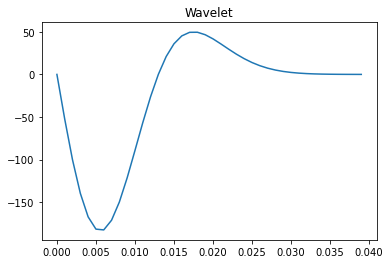

In [20]:
# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

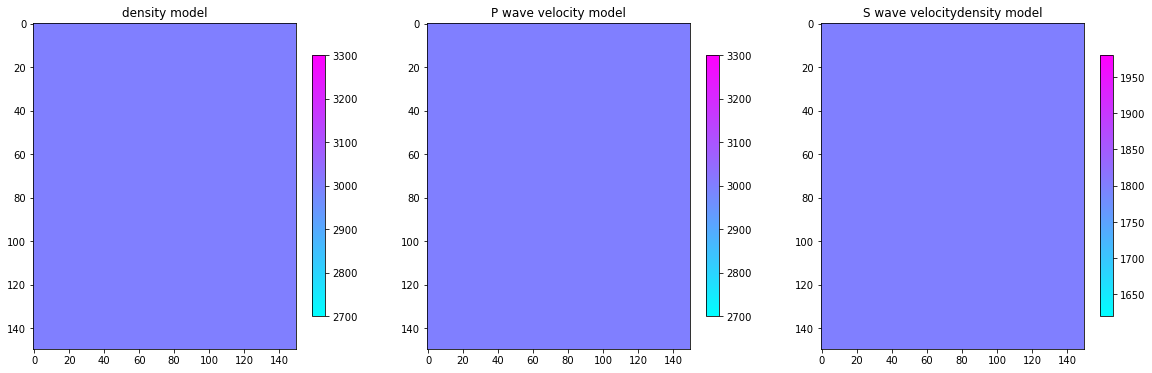

In [21]:
# draw model
test.DrawModel()

In [22]:
test.o24FM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
*************************
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -52.51173747   0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.  

[[ -20.11303289  -49.06013558  -67.61697743  -57.69293621  -67.61697743
   -49.06013558]
 [ -19.43333122  -34.38087869  -30.63887221   42.72219044  -30.63887221
   -34.38087869]
 [   2.39372069  -35.05636976  -22.47171832  209.24010985  -22.47171832
   -35.05636976]
 [ -18.44023407 -101.34403777   18.85314863  226.28213909   18.85314863
  -101.34403777]
 [   2.39372069  -35.05636976  -22.47171832  209.24010985  -22.47171832
   -35.05636976]
 [ -19.43333122  -34.38087869  -30.63887221   42.72219044  -30.63887221
   -34.38087869]]
[[-1.63631983e+08 -2.85678597e+08 -4.34122268e+08 -4.30374559e+08
  -4.34122268e+08 -2.85678597e+08]
 [ 5.88591675e+07  9.35091749e+07 -1.62197052e+08  6.20471416e+08
  -1.62197052e+08  9.35091749e+07]
 [ 5.74801199e+07 -2.30185373e+08 -2.45064477e+08  1.26738918e+09
  -2.45064477e+08 -2.30185373e+08]
 [-5.74801199e+07  2.30185373e+08  2.45064477e+08 -1.26738918e+09
   2.45064477e+08  2.30185373e+08]
 [-5.88591675e+07 -9.35091749e+07  1.62197052e+08 -6.20471416

[[-14.21394735  55.65938646  22.66574781  12.58155897  22.66574781
   55.65938646]
 [ 36.60917796  82.10443984 -57.91084064  24.17980835 -57.91084064
   82.10443984]
 [ 84.06595922  28.04896592 -66.34570493  67.50233678 -66.34570493
   28.04896592]
 [ 74.07441316  20.31751288 -38.09003206  29.34163426 -38.09003206
   20.31751288]
 [ 84.06595922  28.04896592 -66.34570493  67.50233678 -66.34570493
   28.04896592]
 [ 36.60917796  82.10443984 -57.91084064  24.17980835 -57.91084064
   82.10443984]]
[[-5.57225304e+07  4.52913176e+08  3.75376205e+07 -2.07994970e+06
   3.75376205e+07  4.52913176e+08]
 [ 1.91542350e+08  2.32240090e+08 -3.99097428e+08  1.53646381e+08
  -3.99097428e+08  2.32240090e+08]
 [ 9.36114922e+07 -5.45740647e+07  1.25397057e+08  6.00147211e+07
   1.25397057e+08 -5.45740647e+07]
 [-9.36114922e+07  5.45740647e+07 -1.25397057e+08 -6.00147211e+07
  -1.25397057e+08  5.45740647e+07]
 [-1.91542350e+08 -2.32240090e+08  3.99097428e+08 -1.53646381e+08
   3.99097428e+08 -2.32240090e+

   2.23926642e+07 -3.57592740e+07]]
*************************
[[-61.05839742  18.65615618  -9.90288569   1.25694649  -9.90288569
   18.65615618]
 [-30.91933397  56.86276976 -41.33003839  46.63525624 -41.33003839
   56.86276976]
 [-17.42344924  19.29094207 -31.02613923  25.50041171 -31.02613923
   19.29094207]
 [-20.66208917  49.72731151 -38.97707791  46.82449635 -38.97707791
   49.72731151]
 [-17.42344924  19.29094207 -31.02613923  25.50041171 -31.02613923
   19.29094207]
 [-30.91933397  56.86276976 -41.33003839  46.63525624 -41.33003839
   56.86276976]]
[[-61.04173425  32.25452882 -23.5956517   16.95262224 -23.5956517
   32.25452882]
 [ -9.96514484  48.9902004  -41.78029153  48.94944334 -41.78029153
   48.9902004 ]
 [-10.69552287  10.89337842 -25.5935946   20.83718561 -25.5935946
   10.89337842]
 [  1.57494409  40.58295014 -35.34818016  45.8862899  -35.34818016
   40.58295014]
 [-10.69552287  10.89337842 -25.5935946   20.83718561 -25.5935946
   10.89337842]
 [ -9.96514484  48.9902004 

[[-35.17636054  28.10545942 -12.12035027  17.43992392 -12.12035027
   28.10545942]
 [-21.22069752  20.97345247 -22.12578111  16.67406421 -22.12578111
   20.97345247]
 [-31.36109726  30.1057605  -20.06938293  24.20728445 -20.06938293
   30.1057605 ]
 [-21.74496575  26.94418156 -29.41321308  25.72845719 -29.41321308
   26.94418156]
 [-31.36109726  30.1057605  -20.06938293  24.20728445 -20.06938293
   30.1057605 ]
 [-21.22069752  20.97345247 -22.12578111  16.67406421 -22.12578111
   20.97345247]]
[[-6.74747239e+07  1.04253060e+08 -8.41418350e+07  9.92706629e+07
  -8.41418350e+07  1.04253060e+08]
 [-9.19384118e+06 -2.43148050e+07  1.12297913e+07 -3.66645292e+07
   1.12297913e+07 -2.43148050e+07]
 [-5.37027882e+07  7.90446020e+07 -5.43497410e+07  7.99614787e+07
  -5.43497410e+07  7.90446020e+07]
 [ 5.37027882e+07 -7.90446020e+07  5.43497410e+07 -7.99614787e+07
   5.43497410e+07 -7.90446020e+07]
 [ 9.19384118e+06  2.43148050e+07 -1.12297913e+07  3.66645292e+07
  -1.12297913e+07  2.43148050e+

[[-17.57095216   6.61534549  -9.03260328   3.00136092  -9.03260328
    6.61534549]
 [-13.07748215  13.65983628  -1.1022751    6.80982296  -1.1022751
   13.65983628]
 [-27.59846551  19.13035628 -22.01118994  15.11965775 -22.01118994
   19.13035628]
 [-14.09520461  16.81419404  -5.71721948  12.02616027  -5.71721948
   16.81419404]
 [-27.59846551  19.13035628 -22.01118994  15.11965775 -22.01118994
   19.13035628]
 [-13.07748215  13.65983628  -1.1022751    6.80982296  -1.1022751
   13.65983628]]
[[  9388842.13791497  -3390692.35091849  34872929.19640969
    3445574.29478889  34872929.19640965  -3390692.35091852]
 [-58399172.97087316  44268437.38697198 -48190882.57828145
   16343257.11201617 -48190882.57828178  44268437.3869721 ]
 [ 18630239.43083593 -13402526.62095748  16263825.69076863
    9139794.51749736  16263825.69076791 -13402526.62095758]
 [-18630239.43083576  13402526.62095755 -16263825.69076852
   -9139794.5174971  -16263825.69076809  13402526.62095757]
 [ 58399172.97087339 -44268

[[-12.91168057   6.89133801  -4.19524697   2.52021225  -4.19524697
    6.89133801]
 [-19.31205686  19.09520678 -15.88204127  16.56788589 -15.88204127
   19.09520678]
 [-13.26041971  11.22822601  -9.34455536   8.86675901  -9.34455536
   11.22822601]
 [-21.22371703  21.00580564 -18.47829584  18.84392379 -18.47829584
   21.00580564]
 [-13.26041971  11.22822601  -9.34455536   8.86675901  -9.34455536
   11.22822601]
 [-19.31205686  19.09520678 -15.88204127  16.56788589 -15.88204127
   19.09520678]]
[[-79095969.48986456  34281332.48988699 -51396781.8766608
   23101036.00520869 -51396781.87666081  34281332.48988677]
 [ 33240530.90662155  13197231.02585288  11624262.76112986
   18598897.21752547  11624262.76112938  13197231.02585359]
 [-51721854.33769254   1131391.67828777 -24812375.4274404
   -7070225.77083784 -24812375.42744043   1131391.67828717]
 [ 51721854.33769256  -1131391.67828789  24812375.42744032
    7070225.77083796  24812375.42744033  -1131391.67828755]
 [-33240530.90662153 -13197

   78116757.44412789 -75618818.92815699  73623823.58857162]]
*************************
[[-5.55663811 -0.4785659   2.47436912 -3.96480464  2.47436912 -0.4785659 ]
 [-1.86328687  2.00106251  1.79554743 -0.19287717  1.79554743  2.00106251]
 [-9.74756152  3.14112492 -1.81322001 -0.58146431 -1.81322001  3.14112492]
 [-5.36856537  6.01837837 -1.90889911  3.88786683 -1.90889911  6.01837837]
 [-9.74756152  3.14112492 -1.81322001 -0.58146431 -1.81322001  3.14112492]
 [-1.86328687  2.00106251  1.79554743 -0.19287717  1.79554743  2.00106251]]
[[-10.28454421   7.20826297  -3.09154358   4.01199278  -3.09154358
    7.20826297]
 [ -6.16827963   4.33897221  -2.88360267   2.11217442  -2.88360267
    4.33897221]
 [-14.19598963  10.61197055  -7.38488996   7.38642429  -7.38488996
   10.61197055]
 [ -8.67035904   7.82464664  -6.23574615   5.97592709  -6.23574615
    7.82464664]
 [-14.19598963  10.61197055  -7.38488996   7.38642429  -7.38488996
   10.61197055]
 [ -6.16827963   4.33897221  -2.88360267   2.11

[[-0.47497028 -3.58303726  2.09077536 -5.01287084  2.09077536 -3.58303726]
 [-1.05677247 -0.0241005   5.06965298 -2.70234106  5.06965298 -0.0241005 ]
 [-5.95306111  2.45178941 -3.15645893  0.61660873 -3.15645893  2.45178941]
 [-2.6894247   1.42882401  3.22536716 -1.10605277  3.22536716  1.42882401]
 [-5.95306111  2.45178941 -3.15645893  0.61660873 -3.15645893  2.45178941]
 [-1.05677247 -0.0241005   5.06965298 -2.70234106  5.06965298 -0.0241005 ]]
[[  7395447.20590873 -31662587.08932836  17276744.23201519
  -30185559.38986296  17276744.23201529 -31662587.08932839]
 [-13356833.45518834  34234544.93226815 -12160469.35262762
   27487042.14572312 -12160469.35262808  34234544.93226819]
 [  7239857.94535858 -31013805.89444655   8674015.52320583
  -25806134.29644449   8674015.52320582 -31013805.89444664]
 [ -7239857.94535869  31013805.89444622  -8674015.52320591
   25806134.29644453  -8674015.52320615  31013805.89444637]
 [ 13356833.45518838 -34234544.93226826  12160469.35262796
  -27487042.14

[[ 4.49096094 -4.29324687  8.48507528 -6.16241196  8.48507528 -4.29324687]
 [-3.88412977 -0.1705126  -0.9241829  -1.65984905 -0.9241829  -0.1705126 ]
 [ 1.77567476 -1.31622322  5.47325998 -3.10102663  5.47325998 -1.31622322]
 [-5.87691073  1.66170882 -2.65294319  0.01456824 -2.65294319  1.66170882]
 [ 1.77567476 -1.31622322  5.47325998 -3.10102663  5.47325998 -1.31622322]
 [-3.88412977 -0.1705126  -0.9241829  -1.65984905 -0.9241829  -0.1705126 ]]
[[-23305702.74096275   7998813.4468796  -13565779.79362044
    2718919.32055557 -13565779.79362043   7998813.44687939]
 [ 17064033.83940171  -5809913.33679999  11955549.63779408
   -2848169.70614348  11955549.63779372  -5809913.33679973]
 [-17269190.57269683   4916635.70929828  -9014866.42923459
     393871.92653167  -9014866.42923441   4916635.70929788]
 [ 17269190.57269704  -4916635.70929831   9014866.42923479
    -393871.92653139   9014866.42923441  -4916635.70929819]
 [-17064033.83940156   5809913.33680026 -11955549.63779376
    2848169.70

[[-0.59412448 -2.53541315  2.05003119 -3.70936656  2.05003119 -2.53541315]
 [ 4.3502831  -3.73539728  6.66293041 -4.89874487  6.66293041 -3.73539728]
 [-3.34977756 -0.33359486 -0.21480927 -1.83565265 -0.21480927 -0.33359486]
 [ 2.92708937 -2.13698577  5.17497147 -3.26514391  5.17497147 -2.13698577]
 [-3.34977756 -0.33359486 -0.21480927 -1.83565265 -0.21480927 -0.33359486]
 [ 4.3502831  -3.73539728  6.66293041 -4.89874487  6.66293041 -3.73539728]]
[[ 14873379.84136409   8049076.76234788  12373912.94571301
   11366574.98740241  12373912.94571309   8049076.76234835]
 [-11095060.67830564 -12947760.39946371  -4838205.77942744
  -18089626.29869752  -4838205.77942767 -12947760.39946366]
 [  8152204.64779315  14086395.6391918    4027404.59483604
   18158806.7463854    4027404.59483575  14086395.63919165]
 [ -8152204.64779301 -14086395.63919181  -4027404.59483586
  -18158806.74638541  -4027404.59483598 -14086395.63919197]
 [ 11095060.67830584  12947760.39946386   4838205.7794276
   18089626.298

[[ 1.37450489 -4.66283597  3.26874061 -5.62465097  3.26874061 -4.66283597]
 [-2.16646746  2.83217963  0.50445082  1.57458245  0.50445082  2.83217963]
 [-0.90777696 -1.97696576  0.73837726 -2.8909511   0.73837726 -1.97696576]
 [-3.17132217  3.64767225 -0.38848914  2.3474151  -0.38848914  3.64767225]
 [-0.90777696 -1.97696576  0.73837726 -2.8909511   0.73837726 -1.97696576]
 [-2.16646746  2.83217963  0.50445082  1.57458245  0.50445082  2.83217963]]
[[ -7316286.95595508  -6060321.0221248    2668835.76892605
   -8507455.29382466   2668835.76892613  -6060321.02212491]
 [  2197559.4674991   11078120.88079749  -4585433.0655417
   11895656.48988333  -4585433.06554195  11078120.88079742]
 [ -3251304.18981405 -11558118.73514468   4744734.52227173
  -12989470.5818833    4744734.52227161 -11558118.7351448 ]
 [  3251304.18981409  11558118.73514474  -4744734.52227151
   12989470.58188366  -4744734.52227182  11558118.73514458]
 [ -2197559.46749898 -11078120.88079753   4585433.06554198
  -11895656.489

[[ 0.86329151 -0.27683124  3.09409725 -1.43652244  3.09409725 -0.27683124]
 [ 0.23788101 -2.78711991  1.54224613 -3.36008296  1.54224613 -2.78711991]
 [-0.41212932  1.00088732  1.96403732 -0.23805332  1.96403732  1.00088732]
 [-0.98345987 -1.59110351  0.31011631 -2.17297838  0.31011631 -1.59110351]
 [-0.41212932  1.00088732  1.96403732 -0.23805332  1.96403732  1.00088732]
 [ 0.23788101 -2.78711991  1.54224613 -3.36008296  1.54224613 -2.78711991]]
[[-15120965.75995485   5126146.1629589  -17124757.79519081
    5727433.28025032 -17124757.79519072   5126146.162959  ]
 [ 15444968.78986769  -7179855.0857588   19115550.37478553
   -8535731.18885256  19115550.37478535  -7179855.08575866]
 [-16847326.79293234   8174843.90992571 -19114057.29636792
    8793428.60227973 -19114057.29636795   8174843.90992553]
 [ 16847326.79293237  -8174843.90992591  19114057.29636795
   -8793428.60227953  19114057.2963677   -8174843.90992581]
 [-15444968.78986771   7179855.08575889 -19115550.37478532
    8535731.18

   23484665.43496878 -26909154.6691219   26251673.08206197]]
*************************
[[ 4.09618537 -6.30463459  4.44985844 -6.49548575  4.44985844 -6.30463459]
 [ 8.47169419 -6.98047877  9.56515426 -7.38827217  9.56515426 -6.98047877]
 [ 2.89239482 -5.30737958  3.65897966 -5.73309704  3.65897966 -5.30737958]
 [ 8.0078413  -6.58483235  9.16664    -7.01875792  9.16664    -6.58483235]
 [ 2.89239482 -5.30737958  3.65897966 -5.73309704  3.65897966 -5.30737958]
 [ 8.47169419 -6.98047877  9.56515426 -7.38827217  9.56515426 -6.98047877]]
[[ 3.0621523  -5.11794802  3.7727909  -5.40729451  3.7727909  -5.11794802]
 [ 5.6272745  -4.74260638  7.25510009 -5.52248086  7.25510009 -4.74260638]
 [ 1.23784451 -3.56077889  2.23543729 -4.03004267  2.23543729 -3.56077889]
 [ 5.13727631 -4.23261231  6.8043758  -5.02446294  6.8043758  -4.23261231]
 [ 1.23784451 -3.56077889  2.23543729 -4.03004267  2.23543729 -3.56077889]
 [ 5.6272745  -4.74260638  7.25510009 -5.52248086  7.25510009 -4.74260638]]
[[ 20935534

[[ 9.71915779 -7.60310057  9.27011083 -7.3989409   9.27011083 -7.60310057]
 [ 4.5920851  -6.65021776  5.1408457  -6.80879435  5.1408457  -6.65021776]
 [ 9.19980074 -7.108783    8.94587215 -6.99726345  8.94587215 -7.108783  ]
 [ 4.57844862 -6.78072479  5.28714782 -7.02258962  5.28714782 -6.78072479]
 [ 9.19980074 -7.108783    8.94587215 -6.99726345  8.94587215 -7.108783  ]
 [ 4.5920851  -6.65021776  5.1408457  -6.80879435  5.1408457  -6.65021776]]
[[  2821790.67342968 -16459884.08288044   5465474.2345027
  -18259840.81257656   5465474.23450237 -16459884.08288033]
 [  2231833.10427652  10264185.31590701    272265.62576087
   11834168.42856726    272265.62576077  10264185.31590703]
 [  2201180.8623036  -14279288.87376183   4157005.72873638
  -15853307.84149393   4157005.72873618 -14279288.87376165]
 [ -2201180.86230376  14279288.87376153  -4157005.72873642
   15853307.84149407  -4157005.72873646  14279288.87376148]
 [ -2231833.10427628 -10264185.31590674   -272265.62576072
  -11834168.428

[[ 5.70840161 -6.23421258  5.98302696 -6.28833759  5.98302696 -6.23421258]
 [ 7.36550204 -6.42843963  6.84191899 -6.17303486  6.84191899 -6.42843963]
 [ 6.00625365 -6.80969793  6.49070746 -6.9654483   6.49070746 -6.80969793]
 [ 7.12604702 -6.18777725  6.71527985 -5.98999639  6.71527985 -6.18777725]
 [ 6.00625365 -6.80969793  6.49070746 -6.9654483   6.49070746 -6.80969793]
 [ 7.36550204 -6.42843963  6.84191899 -6.17303486  6.84191899 -6.42843963]]
[[   382926.09000146  14517757.57430092   -667572.63868519
   14969843.1997005    -667572.63868536  14517757.57430094]
 [  6540742.15332399 -21203622.42443262   7291331.31540457
  -21467272.2400108    7291331.31540427 -21203622.42443236]
 [ -3697158.31660946  18186199.22008197  -4171090.50824125
   18331233.63075701  -4171090.50824119  18186199.22008168]
 [  3697158.31660988 -18186199.22008156   4171090.5082415
  -18331233.63075667   4171090.5082411  -18186199.22008191]
 [ -6540742.15332402  21203622.42443264  -7291331.31540439
   21467272.240

[[ 5.20096453 -5.65719964  4.48640773 -5.37249737  4.48640773 -5.65719964]
 [ 7.26065279 -6.43776598  7.47471793 -6.40608773  7.47471793 -6.43776598]
 [ 5.04926628 -5.49461878  4.55799125 -5.32607063  4.55799125 -5.49461878]
 [ 7.3893039  -6.67928998  7.66040261 -6.6732282   7.66040261 -6.67928998]
 [ 5.04926628 -5.49461878  4.55799125 -5.32607063  4.55799125 -5.49461878]
 [ 7.26065279 -6.43776598  7.47471793 -6.40608773  7.47471793 -6.43776598]]
[[ 10101655.11200676 -20000852.39227928   9699651.24696115
  -19111836.37819324   9699651.24696128 -20000852.39227882]
 [ -3984431.46240641  14237153.32324029  -3271714.48114369
   13279213.7172889   -3271714.48114419  14237153.3232403 ]
 [  6355093.01415116 -16745721.78039154   5492815.98853464
  -15728009.47015869   5492815.9885347  -16745721.78039167]
 [ -6355093.01415082  16745721.78039192  -5492815.98853456
   15728009.47015885  -5492815.9885348   16745721.78039164]
 [  3984431.46240608 -14237153.32324034   3271714.48114412
  -13279213.71

[[ 5.55869163 -5.36165715  6.06317065 -5.67351745  6.06317065 -5.36165715]
 [ 4.50169445 -5.07080905  4.66073046 -5.0431263   4.66073046 -5.07080905]
 [ 5.50451396 -5.23054219  6.11466869 -5.59348263  6.11466869 -5.23054219]
 [ 4.08076375 -4.76766541  4.31651266 -4.78100624  4.31651266 -4.76766541]
 [ 5.50451396 -5.23054219  6.11466869 -5.59348263  6.11466869 -5.23054219]
 [ 4.50169445 -5.07080905  4.66073046 -5.0431263   4.66073046 -5.07080905]]
[[-15267942.41797552    269845.26320855 -14875016.29983635
     111395.62998794 -14875016.29983648    269845.26320851]
 [ 19091248.24725655  -4208686.01280949  18898250.39983559
   -4086778.17347945  18898250.399835    -4208686.01280952]
 [-17199659.80042194   2149946.92865361 -16682092.76854052
    1853010.21240032 -16682092.76854086   2149946.92865299]
 [ 17199659.80042185  -2149946.92865333  16682092.76854084
   -1853010.21240021  16682092.7685408   -2149946.92865323]
 [-19091248.24725635   4208686.01280949 -18898250.39983515
    4086778.17

  -3335191.74070854  3322279.84373213]]
*************************
[[ 4.11584099 -3.94112039  3.96593269 -3.81664543  3.96593269 -3.94112039]
 [ 6.87581105 -6.72403316  6.80080384 -6.69231109  6.80080384 -6.72403316]
 [ 4.00886222 -4.05339232  4.03687831 -4.01732429  4.03687831 -4.05339232]
 [ 6.89300241 -6.70627437  6.84803895 -6.68967014  6.84803895 -6.70627437]
 [ 4.00886222 -4.05339232  4.03687831 -4.01732429  4.03687831 -4.05339232]
 [ 6.87581105 -6.72403316  6.80080384 -6.69231109  6.80080384 -6.72403316]]
[[ 4.7438375  -3.8771252   4.74938697 -3.83801496  4.74938697 -3.8771252 ]
 [ 5.67080166 -6.58668363  6.02043624 -6.7609351   6.02043624 -6.58668363]
 [ 4.2379884  -3.56230541  4.40862411 -3.60565943  4.40862411 -3.56230541]
 [ 5.60897778 -6.49749574  5.9873673  -6.68715937  5.9873673  -6.49749574]
 [ 4.2379884  -3.56230541  4.40862411 -3.60565943  4.40862411 -3.56230541]
 [ 5.67080166 -6.58668363  6.02043624 -6.7609351   6.02043624 -6.58668363]]
[[ 14862413.76538559  -6724828.7

[[ 5.67588672 -7.02769482  5.71267304 -7.03816548  5.71267304 -7.02769482]
 [ 4.37285884 -3.0531219   4.53826524 -3.10361144  4.53826524 -3.0531219 ]
 [ 5.52360497 -6.88174543  5.60579063 -6.92027041  5.60579063 -6.88174543]
 [ 4.27546021 -3.01498074  4.51564201 -3.10058496  4.51564201 -3.01498074]
 [ 5.52360497 -6.88174543  5.60579063 -6.92027041  5.60579063 -6.88174543]
 [ 4.37285884 -3.0531219   4.53826524 -3.10361144  4.53826524 -3.0531219 ]]
[[ -612892.57340473  1148204.77906455  1868754.28715681   446791.40688767
   1868754.28715703  1148204.77906457]
 [ 3421404.66783736 -3541194.4601349   1094611.60055869 -2901222.96527202
   1094611.60055845 -3541194.46013493]
 [-1369349.98754377  1197684.4526599   1046728.1249508    517928.0195454
   1046728.12495065  1197684.45265961]
 [ 1369349.98754388 -1197684.4526597  -1046728.12495052  -517928.01954534
  -1046728.12495093 -1197684.45265983]
 [-3421404.66783748  3541194.46013521 -1094611.60055801  2901222.96527206
  -1094611.6005587   354

[[ 3.35745888 -3.36281097  3.52852159 -3.50387423  3.52852159 -3.36281097]
 [ 5.38537112 -5.61043909  5.63263894 -5.64879574  5.63263894 -5.61043909]
 [ 3.16918146 -3.14013345  3.45710914 -3.34018118  3.45710914 -3.14013345]
 [ 5.17364812 -5.46382483  5.44004245 -5.51239698  5.44004245 -5.46382483]
 [ 3.16918146 -3.14013345  3.45710914 -3.34018118  3.45710914 -3.14013345]
 [ 5.38537112 -5.61043909  5.63263894 -5.64879574  5.63263894 -5.61043909]]
[[-2879940.94712294 -8389354.54115473 -4235631.5884737  -7524389.62011025
  -4235631.58847346 -8389354.54115498]
 [ 6527737.74339821  4702916.90409237  8134014.56789758  3753689.11360366
   8134014.56789708  4702916.90409238]
 [-5620998.77146011 -5722867.23417624 -7099731.79985902 -4848475.94754687
  -7099731.79985883 -5722867.23417627]
 [ 5620998.7714596   5722867.23417567  7099731.79985876  4848475.94754684
   7099731.79985872  5722867.234176  ]
 [-6527737.74339821 -4702916.90409234 -8134014.56789735 -3753689.11360383
  -8134014.56789759 -47

[[ 5.80826453 -4.81546217  5.77913163 -4.76805191  5.77913163 -4.81546217]
 [ 3.11522736 -4.15817835  3.41675315 -4.31587301  3.41675315 -4.15817835]
 [ 5.43844827 -4.52878389  5.46211627 -4.50723987  5.46211627 -4.52878389]
 [ 3.10395507 -4.14715737  3.4476418  -4.32662719  3.4476418  -4.14715737]
 [ 5.43844827 -4.52878389  5.46211627 -4.50723987  5.46211627 -4.52878389]
 [ 3.11522736 -4.15817835  3.41675315 -4.31587301  3.41675315 -4.15817835]]
[[ 7874341.09093754 -4767124.77621242  8863018.23198214 -5523740.78322227
   8863018.2319817  -4767124.77621261]
 [-5867548.55666994  2275875.76567404 -6604924.64537298  2914699.14070883
  -6604924.64537305  2275875.765674  ]
 [ 7606749.45936938 -3859358.76092445  8379697.84356537 -4511488.96000927
   8379697.84356527 -3859358.76092444]
 [-7606749.45936909  3859358.76092492 -8379697.84356484  4511488.96000958
  -8379697.84356519  3859358.76092395]
 [ 5867548.55667    -2275875.7656739   6604924.645373   -2914699.14070907
   6604924.64537283 -22

[[ 3.56397626 -4.80796882  3.78181021 -4.90707502  3.78181021 -4.80796882]
 [ 4.99007104 -3.72665347  4.88085085 -3.65729926  4.88085085 -3.72665347]
 [ 3.64553447 -4.93259388  3.91954083 -5.06183576  3.91954083 -4.93259388]
 [ 4.83476694 -3.59013919  4.76043596 -3.53740384  4.76043596 -3.59013919]
 [ 3.64553447 -4.93259388  3.91954083 -5.06183576  3.91954083 -4.93259388]
 [ 4.99007104 -3.72665347  4.88085085 -3.65729926  4.88085085 -3.72665347]]
[[ -3868485.34412499   8401826.92541436  -3787222.4767078
    8674607.86710343  -3787222.47670769   8401826.92541484]
 [  6818127.23557017 -10999406.93129199   6716461.96776573
  -11252959.11319694   6716461.96776515 -10999406.93129174]
 [ -5689888.7772694    9644043.31296468  -5476493.86496579
    9844357.6248473   -5476493.86496566   9644043.31296435]
 [  5689888.77726971  -9644043.31296464   5476493.86496587
   -9844357.62484731   5476493.86496589  -9644043.31296435]
 [ -6818127.23557029  10999406.93129209  -6716461.96776546
   11252959.113

[[ 3.8235159  -3.99411416  3.75278752 -3.99523507  3.75278752 -3.99411416]
 [ 3.95426169 -3.95150429  4.33511897 -4.08512895  4.33511897 -3.95150429]
 [ 3.50056866 -3.62739914  3.48722563 -3.65914874  3.48722563 -3.62739914]
 [ 3.90731324 -3.95733208  4.30899578 -4.10087532  4.30899578 -3.95733208]
 [ 3.50056866 -3.62739914  3.48722563 -3.65914874  3.48722563 -3.62739914]
 [ 3.95426169 -3.95150429  4.33511897 -4.08512895  4.33511897 -3.95150429]]
[[  3923267.92356159 -13631301.41914819   4280735.18294527
  -13557698.36749091   4280735.18294509 -13631301.41914794]
 [ -1794555.18633912  11510090.78905328  -1887006.51031618
   11324834.78398539  -1887006.51031667  11510090.78905353]
 [  2789341.94708651 -12588250.14432121   2903481.4532427
  -12419075.20788665   2903481.45324258 -12588250.14432153]
 [ -2789341.94708682  12588250.14432119  -2903481.45324267
   12419075.20788663  -2903481.4532428   12588250.14432103]
 [  1794555.18633929 -11510090.78905322   1887006.51031658
  -11324834.783

    7601509.12853681  -8652452.79256299   8776435.95781482]]
*************************
[[ 4.99957729 -4.11586798  5.18753002 -4.19223531  5.18753002 -4.11586798]
 [ 2.66767246 -3.58656031  2.6712919  -3.58975219  2.6712919  -3.58656031]
 [ 4.96169604 -4.12069608  5.17848459 -4.20965112  5.17848459 -4.12069608]
 [ 2.55368133 -3.47949688  2.58937816 -3.49986065  2.58937816 -3.47949688]
 [ 4.96169604 -4.12069608  5.17848459 -4.20965112  5.17848459 -4.12069608]
 [ 2.66767246 -3.58656031  2.6712919  -3.58975219  2.6712919  -3.58656031]]
[[ 3.99672594 -3.15666713  4.34930826 -3.33678447  4.34930826 -3.15666713]
 [ 2.34441815 -3.41956525  2.466037   -3.46276128  2.466037   -3.41956525]
 [ 3.8782821  -3.04286492  4.2614953  -3.23669654  4.2614953  -3.04286492]
 [ 2.1323954  -3.2286691   2.27784514 -3.28513476  2.27784514 -3.2286691 ]
 [ 3.8782821  -3.04286492  4.2614953  -3.23669654  4.2614953  -3.04286492]
 [ 2.34441815 -3.41956525  2.466037   -3.46276128  2.466037   -3.41956525]]
[[-8314535.

[[ 2.41601869 -3.29579955  2.43064693 -3.29198151  2.43064693 -3.29579955]
 [ 5.21725383 -4.29150106  5.25513403 -4.30482919  5.25513403 -4.29150106]
 [ 2.33097877 -3.271533    2.40675208 -3.30003036  2.40675208 -3.271533  ]
 [ 5.18163218 -4.2522337   5.23076899 -4.27042769  5.23076899 -4.2522337 ]
 [ 2.33097877 -3.271533    2.40675208 -3.30003035  2.40675208 -3.271533  ]
 [ 5.21725385 -4.29150104  5.25513405 -4.30482917  5.25513405 -4.29150104]]
[[ 7189066.3032367   -640191.98822122  6406234.21282254   -20162.69813003
   6406234.21312935  -640191.98706858]
 [-4547337.60768832 -1832638.32073106 -3693049.63409068 -2483422.730855
  -3693049.63390279 -1832638.32002518]
 [ 5232657.19478546  1030531.77488772  4407162.33289705  1668603.56245361
   4407162.33296002  1030531.77512514]
 [-5232657.15384949 -1030531.7327889  -4407162.29008492 -1668603.51940111
  -4407162.29014843 -1030531.73302646]
 [ 4547337.72399856  1832638.44025103  3693049.75557775  2483422.85300413
   3693049.75538971  1832

[[ 4.16544949 -4.64429854  4.22391184 -4.69520621  4.22391182 -4.64429862]
 [ 2.68027061 -2.32679236  2.86224699 -2.38217744  2.86224696 -2.32679245]
 [ 4.03636802 -4.46893108  4.11098415 -4.52918835  4.11098412 -4.46893117]
 [ 2.59916909 -2.29056367  2.80760575 -2.35879104  2.80760573 -2.29056376]
 [ 4.036372   -4.468927    4.11098828 -4.52918421  4.11098825 -4.46892709]
 [ 2.68028358 -2.32677911  2.86226041 -2.38216396  2.86226039 -2.32677919]]
[[-4106260.78509345 -3542047.88017624 -2866415.21792853 -3947159.13638164
  -2866414.99851812 -3542047.17079483]
 [ 5366204.42954596  2408061.08145748  4231724.48683853  2770770.08779168
   4231724.62069403  2408061.51403351]
 [-4356218.49798075 -3531328.55198027 -3175653.36676173 -3919027.16722838
  -3175653.32177055 -3531328.40661719]
 [ 4356254.98356264  3531365.87563158  3175691.20214685  3919065.17469207
   3175691.15715562  3531365.73026843]
 [-5366119.80494549 -2407974.58080027 -4231636.84138833 -2770682.05751182
  -4231636.97524378 -24

*************************
[[ 3.29428708 -3.03665866  3.25670618 -2.99119708  3.25670317 -3.03666756]
 [ 2.98746364 -2.94099906  2.67538028 -2.80170013  2.67537708 -2.94100848]
 [ 3.54866833 -3.35410475  3.53496159 -3.31930677  3.53495829 -3.35411447]
 [ 3.0089036  -2.94800231  2.7147887  -2.81799017  2.71478536 -2.94801214]
 [ 3.54909745 -3.3536679   3.53540314 -3.31886364  3.53539984 -3.35367762]
 [ 2.98869446 -2.93974674  2.67664566 -2.80043036  2.67664247 -2.93975616]]
[[ 3.46331571 -2.78064111  3.52642461 -2.79464607  3.52642057 -2.78065295]
 [ 3.5438331  -4.07623249  3.35861174 -3.99002972  3.35860746 -4.076245  ]
 [ 3.59997302 -2.97282422  3.69991048 -3.00356275  3.69990606 -2.97283714]
 [ 3.5026963  -4.02568801  3.33249596 -3.94771454  3.33249149 -4.02570106]
 [ 3.60054226 -2.97224489  3.70049595 -3.00297522  3.70049153 -2.97225781]
 [ 3.54545193 -4.07458584  3.36027529 -3.9883605   3.36027102 -4.07459835]]
[[-2437419.96064906  6404820.02003895 -3101638.13197951  6507935.5690055

  -13587359.23768881  12974167.78277979 -13031267.37806373]]
*************************
[[ 0.6541396  -0.93100849  0.33064063 -0.79570243  0.33042878 -0.93155714]
 [ 3.19648923 -2.66440724  2.95793011 -2.51505069  2.9577088  -2.66497946]
 [ 0.96027116 -1.13754285  0.66935454 -1.01752643  0.66912745 -1.13812945]
 [ 3.34183223 -2.7838746   3.1044704  -2.63432376  3.10424137 -2.78446604]
 [ 0.98485891 -1.11262636  0.69447016 -0.99234411  0.69424307 -1.11321296]
 [ 3.25782846 -2.60228188  3.02053144 -2.45229     3.02031013 -2.60285411]]
[[ 1.64413033 -2.34291019  1.34671297 -2.20918127  1.34644541 -2.34359736]
 [ 3.97156979 -3.13368178  3.86375201 -3.05800918  3.86347275 -3.13439785]
 [ 1.80675621 -2.41216057  1.54662435 -2.29694231  1.54633795 -2.41289428]
 [ 4.11405055 -3.23166512  4.01275457 -3.1579748   4.01246577 -3.23240475]
 [ 1.83732495 -2.38119235  1.57783448 -2.26565117  1.57754808 -2.38192606]
 [ 4.04714595 -3.05715992  3.94084629 -2.98072325  3.94056703 -3.057876  ]]
[[ 6609858.

[[ 2.11144553 -2.3309421   1.75820996 -2.16758679  1.75190919 -2.34506902]
 [-0.09321803 -1.43129801 -0.30914203 -1.33993957 -0.31562413 -1.44580868]
 [ 2.87901353 -1.96153617  2.53310443 -1.79460056  2.52651247 -1.97627916]
 [ 0.58221185 -1.08617979  0.38313772 -0.99772702  0.37650896 -1.10100056]
 [ 3.38891424 -1.44774826  3.04923304 -1.27769031  3.04264109 -1.46249125]
 [ 0.9866577  -0.34386703  0.78283479 -0.24644535  0.7763527  -0.3583777 ]]
[[ 7858815.00489867  3124219.99602038  8480151.94697894  2685810.62272126
   8501116.23161085  3168004.75341082]
 [ 3862576.55617706  7592743.4029947   3333680.70862557  8191872.97503161
   3346321.37436898  7619129.78030631]
 [ 6095826.48604043  1027243.42997219  6709564.54113252   550063.4075895
   6713788.45729242  1036058.14872454]
 [ 3088408.89662499  8242899.38302966  2612425.9870158   8789260.35888398
   2608202.07085581  8234084.66427743]
 [ 7421231.02297531  3786138.13759862  8102526.15732864  3263489.21172511
   8089885.49158457  375

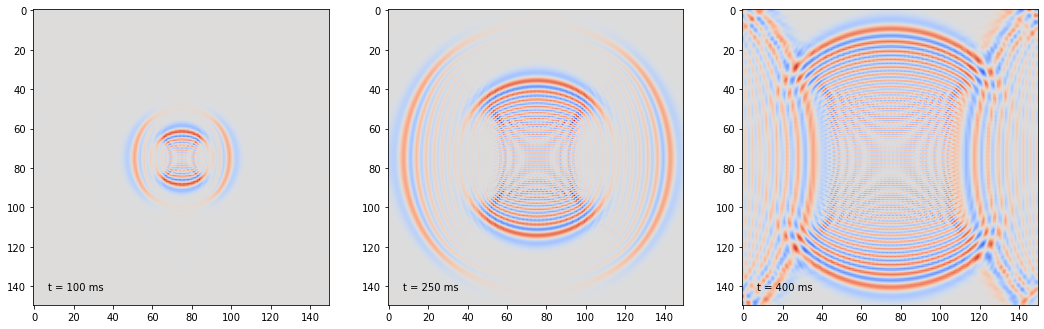

In [8]:
test.DrawXWaveField([100,250, 400])

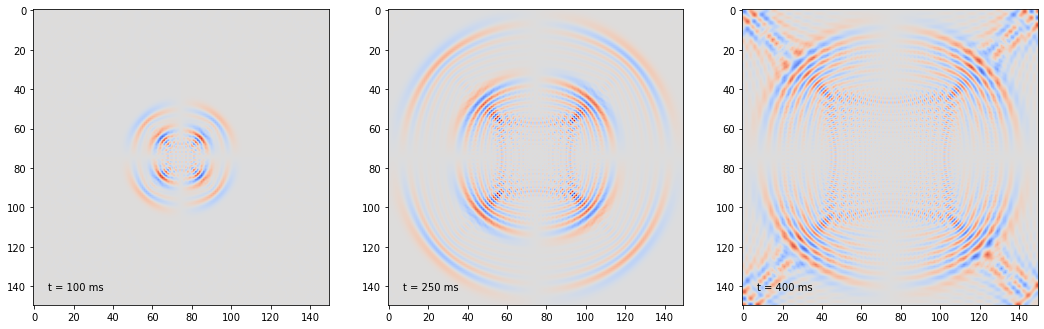

In [9]:
test.DrawZWaveField([100,250, 400])

In [10]:
test_2 = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)
test.o4xFM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

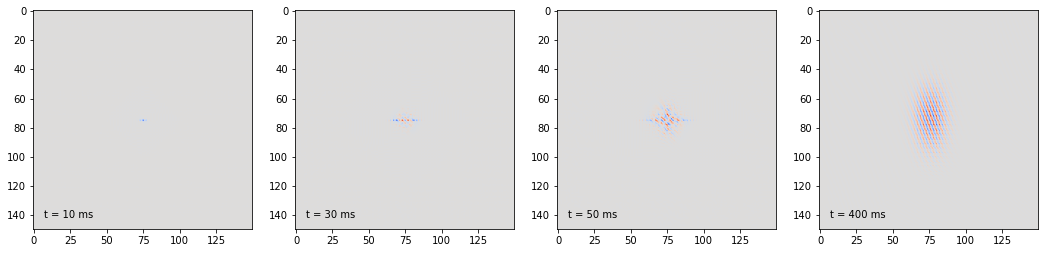

In [11]:
test.DrawXWaveField([10, 30, 50, 400])

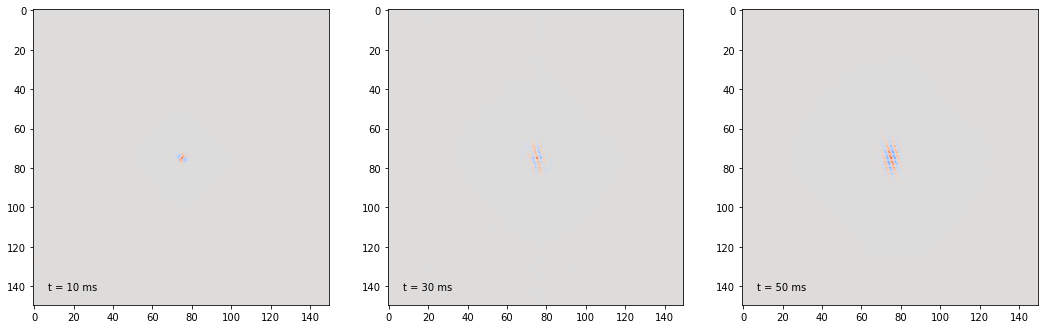

In [12]:
test.DrawZWaveField([10, 30, 50])

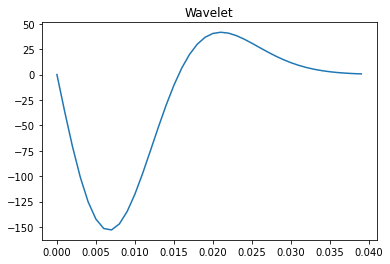

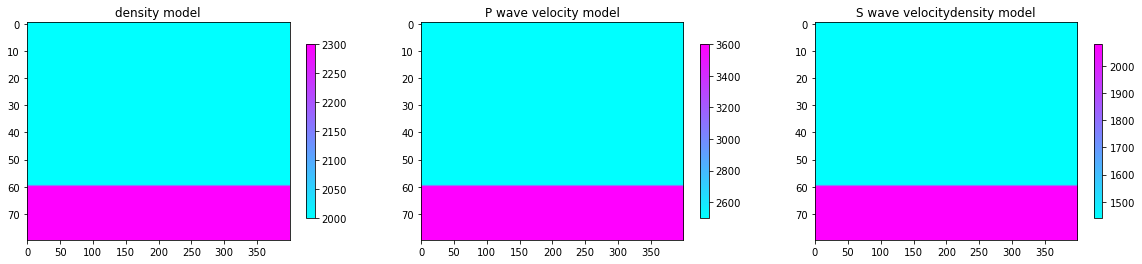

In [21]:
f_m = 25
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

nx = 400
nz = 80
nt = 1900
dx = dz =7.5
dt = 0.6 / 1000
x_max = nx * dx 
z_max = nz * dz
t_max = nt * dt

pmodel = np.ones((nx,nz), dtype=float)
vsmodel = np.ones((nx,nz), dtype=float)
vpmodel = np.ones((nx,nz), dtype=float)

pmodel[:, 0:60] = 2000
vpmodel[:, 0:60] = 2500
vsmodel[:, 0:60] = 1440

pmodel[:, 60:] = 2300
vpmodel[:, 60:] = 3600
vsmodel[:, 60:] = 2080

pml_x = 10
pml_z = 10

kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z = FristOlderForward_PML.Cal_Auxiliary_Para(vsmodel, nx, nz, x_max, z_max, pml_x, pml_z)
test_3 = FristOlderForward_PML(pmodel, vpmodel, vsmodel, t_max, x_max, z_max, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z)
test_3.DrawModel()

In [22]:
wavelet_position_pml = [11,100]  # [z,x]
test_3.o24FM(source_array, wavelet_position_pml, wavalet_direction='x')

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -36.63215091   0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -10.35434876   0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         18.29546404  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

<ipython-input-12-f32c1f2a0346>:350: RuntimeWarning: invalid value encountered in true_divide
  return array / _max


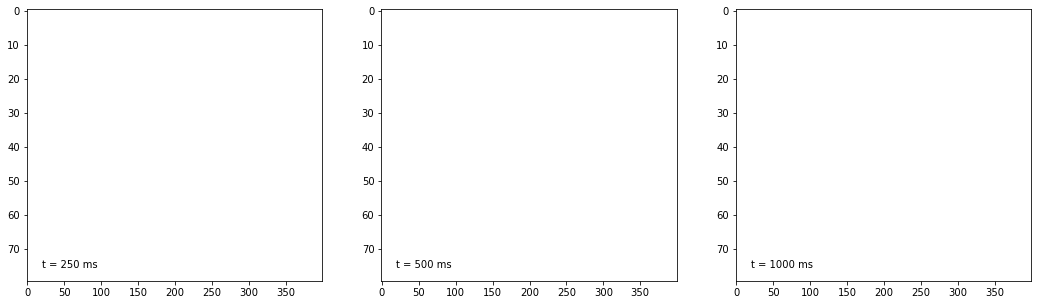

In [22]:
iterations_to_show = [250, 500, 1000]

fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,5))
        
for j, ax in enumerate(axs):
    ax.imshow(test_3.RangeInOne(test_3._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='quadric', aspect='auto')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

In [10]:
print(test_3._vx)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
